***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.4)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While changing the primary capsule dimension ($P_{capsule} = 16D$). Training without $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "7" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  7
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_2_4')

FOLDER CREATED =  ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 16

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 8)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5161 - prediction_coarse_accuracy: 0.4782 - prediction_medium_accuracy: 0.2266 - prediction_fine_accuracy: 0.0126
  • Coarse Accuracy = 47.82% | Val_Accuracy = 52.24% | LossWeight = 0.36 
  • Medium Accuracy = 22.66% | Val_Accuracy = 31.02% | LossWeight = 0.48 
  • Fine   Accuracy = 1.26% | Val_Accuracy = 1.28% | LossWeight = 0.16 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.01280, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 66s 73ms/step - loss: 0.5161 - prediction_coarse_accuracy: 0.4782 - prediction_medium_accuracy: 0.2266 - prediction_fine_accuracy: 0.0126 - val_loss: 0.4468 - val_prediction_coarse_accuracy: 0.5224 - val_prediction_medium_accuracy: 0.3102 - val_prediction_fine_accuracy: 0.0128 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3817 - prediction_coarse_accu

781/781 [==============================] - 69s 88ms/step - loss: 0.2293 - prediction_coarse_accuracy: 0.8426 - prediction_medium_accuracy: 0.7530 - prediction_fine_accuracy: 0.0100 - val_loss: 0.2201 - val_prediction_coarse_accuracy: 0.8078 - val_prediction_medium_accuracy: 0.6976 - val_prediction_fine_accuracy: 0.0100 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.2209 - prediction_coarse_accuracy: 0.8551 - prediction_medium_accuracy: 0.7715 - prediction_fine_accuracy: 0.0122
  • Coarse Accuracy = 85.51% | Val_Accuracy = 81.16% | LossWeight = 0.25 
  • Medium Accuracy = 77.15% | Val_Accuracy = 69.42% | LossWeight = 0.35 
  • Fine   Accuracy = 1.22% | Val_Accuracy = 2.09% | LossWeight = 0.40 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.04800
781/781 [==============================] - 70s 89ms/step - loss: 0.2209 - prediction_coarse_accuracy: 0.8551 - prediction_medium_accuracy: 0.7715 - prediction_fine_accuracy: 0.0122 - val_lo

781/781 [==============================] - 69s 88ms/step - loss: 0.1646 - prediction_coarse_accuracy: 0.9192 - prediction_medium_accuracy: 0.8871 - prediction_fine_accuracy: 0.1491 - val_loss: 0.1858 - val_prediction_coarse_accuracy: 0.8374 - val_prediction_medium_accuracy: 0.7353 - val_prediction_fine_accuracy: 0.1438 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1596 - prediction_coarse_accuracy: 0.9243 - prediction_medium_accuracy: 0.8933 - prediction_fine_accuracy: 0.1688
  • Coarse Accuracy = 92.43% | Val_Accuracy = 83.84% | LossWeight = 0.21 
  • Medium Accuracy = 89.33% | Val_Accuracy = 74.02% | LossWeight = 0.26 
  • Fine   Accuracy = 16.88% | Val_Accuracy = 14.98% | LossWeight = 0.53 

Epoch 19: val_prediction_fine_accuracy improved from 0.14380 to 0.14980, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 62s 80ms/step - loss: 0.1596 - prediction_coarse

781/781 [==============================] - 68s 87ms/step - loss: 0.1373 - prediction_coarse_accuracy: 0.9433 - prediction_medium_accuracy: 0.9248 - prediction_fine_accuracy: 0.2636 - val_loss: 0.1693 - val_prediction_coarse_accuracy: 0.8464 - val_prediction_medium_accuracy: 0.7558 - val_prediction_fine_accuracy: 0.2333 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1366 - prediction_coarse_accuracy: 0.9447 - prediction_medium_accuracy: 0.9280 - prediction_fine_accuracy: 0.2722
  • Coarse Accuracy = 94.47% | Val_Accuracy = 85.01% | LossWeight = 0.19 
  • Medium Accuracy = 92.80% | Val_Accuracy = 75.53% | LossWeight = 0.22 
  • Fine   Accuracy = 27.22% | Val_Accuracy = 23.50% | LossWeight = 0.59 

Epoch 28: val_prediction_fine_accuracy improved from 0.23330 to 0.23500, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 71s 91ms/step - loss: 0.1366 - prediction_coarse

781/781 [==============================] - 67s 86ms/step - loss: 0.1277 - prediction_coarse_accuracy: 0.9501 - prediction_medium_accuracy: 0.9360 - prediction_fine_accuracy: 0.3193 - val_loss: 0.1631 - val_prediction_coarse_accuracy: 0.8535 - val_prediction_medium_accuracy: 0.7605 - val_prediction_fine_accuracy: 0.2706 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1273 - prediction_coarse_accuracy: 0.9513 - prediction_medium_accuracy: 0.9366 - prediction_fine_accuracy: 0.3318
  • Coarse Accuracy = 95.13% | Val_Accuracy = 85.35% | LossWeight = 0.19 
  • Medium Accuracy = 93.66% | Val_Accuracy = 75.94% | LossWeight = 0.22 
  • Fine   Accuracy = 33.18% | Val_Accuracy = 27.90% | LossWeight = 0.60 

Epoch 37: val_prediction_fine_accuracy improved from 0.27060 to 0.27900, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 64s 82ms/step - loss: 0.1273 - prediction_coarse

Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.1212 - prediction_coarse_accuracy: 0.9552 - prediction_medium_accuracy: 0.9437 - prediction_fine_accuracy: 0.3758
  • Coarse Accuracy = 95.52% | Val_Accuracy = 85.46% | LossWeight = 0.19 
  • Medium Accuracy = 94.37% | Val_Accuracy = 76.59% | LossWeight = 0.21 
  • Fine   Accuracy = 37.58% | Val_Accuracy = 30.92% | LossWeight = 0.60 

Epoch 46: val_prediction_fine_accuracy improved from 0.30510 to 0.30920, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 63s 80ms/step - loss: 0.1212 - prediction_coarse_accuracy: 0.9552 - prediction_medium_accuracy: 0.9437 - prediction_fine_accuracy: 0.3758 - val_loss: 0.1553 - val_prediction_coarse_accuracy: 0.8546 - val_prediction_medium_accuracy: 0.7659 - val_prediction_fine_accuracy: 0.3092 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.1208 - prediction

781/781 [==============================] - 51s 65ms/step - loss: 0.1184 - prediction_coarse_accuracy: 0.9573 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.4063 - val_loss: 0.1527 - val_prediction_coarse_accuracy: 0.8584 - val_prediction_medium_accuracy: 0.7711 - val_prediction_fine_accuracy: 0.3295 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.1179 - prediction_coarse_accuracy: 0.9573 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.4072
  • Coarse Accuracy = 95.73% | Val_Accuracy = 85.77% | LossWeight = 0.19 
  • Medium Accuracy = 94.60% | Val_Accuracy = 77.05% | LossWeight = 0.21 
  • Fine   Accuracy = 40.72% | Val_Accuracy = 33.12% | LossWeight = 0.60 

Epoch 55: val_prediction_fine_accuracy improved from 0.32950 to 0.33120, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 51s 66ms/step - loss: 0.1179 - prediction_coarse

Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.1168 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9475 - prediction_fine_accuracy: 0.4231
  • Coarse Accuracy = 95.84% | Val_Accuracy = 85.96% | LossWeight = 0.19 
  • Medium Accuracy = 94.75% | Val_Accuracy = 77.19% | LossWeight = 0.21 
  • Fine   Accuracy = 42.31% | Val_Accuracy = 34.06% | LossWeight = 0.60 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.34240
781/781 [==============================] - 49s 63ms/step - loss: 0.1168 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9475 - prediction_fine_accuracy: 0.4231 - val_loss: 0.1510 - val_prediction_coarse_accuracy: 0.8596 - val_prediction_medium_accuracy: 0.7719 - val_prediction_fine_accuracy: 0.3406 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.1167 - prediction_coarse_accuracy: 0.9582 - prediction_medium_accuracy: 0.9469 - prediction_fine_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.1156 - prediction_coarse_accuracy: 0.9568 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.4421
  • Coarse Accuracy = 95.68% | Val_Accuracy = 86.11% | LossWeight = 0.19 
  • Medium Accuracy = 94.60% | Val_Accuracy = 77.56% | LossWeight = 0.22 
  • Fine   Accuracy = 44.21% | Val_Accuracy = 35.98% | LossWeight = 0.59 

Epoch 82: val_prediction_fine_accuracy did not improve from 0.36030
781/781 [==============================] - 84s 108ms/step - loss: 0.1156 - prediction_coarse_accuracy: 0.9568 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.4421 - val_loss: 0.1491 - val_prediction_coarse_accuracy: 0.8611 - val_prediction_medium_accuracy: 0.7756 - val_prediction_fine_accuracy: 0.3598 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.1159 - prediction_coarse_accuracy: 0.9578 - prediction_medium_accuracy: 0.9487 - prediction_fine_accuracy: 0.4439
  • Coa

781/781 [==============================] - 65s 83ms/step - loss: 0.1146 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9481 - prediction_fine_accuracy: 0.4451 - val_loss: 0.1490 - val_prediction_coarse_accuracy: 0.8615 - val_prediction_medium_accuracy: 0.7763 - val_prediction_fine_accuracy: 0.3609 - lr: 1.5690e-05
Epoch 92/100
781/781 [==============================] - ETA: 0s - loss: 0.1146 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.9511 - prediction_fine_accuracy: 0.4529
  • Coarse Accuracy = 96.04% | Val_Accuracy = 86.13% | LossWeight = 0.19 
  • Medium Accuracy = 95.11% | Val_Accuracy = 77.64% | LossWeight = 0.21 
  • Fine   Accuracy = 45.29% | Val_Accuracy = 36.16% | LossWeight = 0.60 

Epoch 92: val_prediction_fine_accuracy did not improve from 0.36200
781/781 [==============================] - 64s 82ms/step - loss: 0.1146 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.9511 - prediction_fine_accuracy: 0.4529 - 

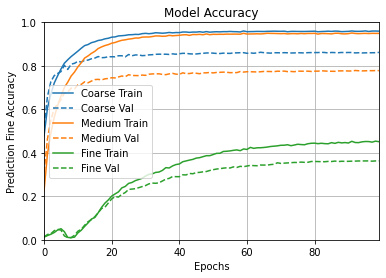

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

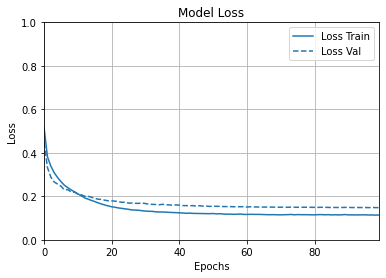

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 22ms/step - loss: 0.3679 - prediction_coarse_loss: 0.1046 - prediction_medium_loss: 0.1691 - prediction_fine_loss: 0.5218 - prediction_coarse_accuracy: 0.8619 - prediction_medium_accuracy: 0.7782 - prediction_fine_accuracy: 0.3633
1. loss ==> 0.3679344058036804
2. prediction_coarse_loss ==> 0.10460733622312546
3. prediction_medium_loss ==> 0.16910330951213837
4. prediction_fine_loss ==> 0.521846354007721
5. prediction_coarse_accuracy ==> 0.8618999719619751
6. prediction_medium_accuracy ==> 0.7781999707221985
7. prediction_fine_accuracy ==> 0.36329999566078186
313/313 [==============================] - 6s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

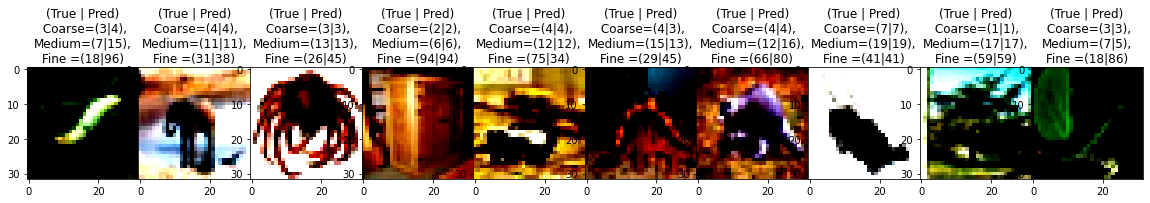

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 719   13   17   31  185   13   10   12]
 [   6 1373   26   32   39   21    1    2]
 [   7   30 1371   15   22   16   11   28]
 [  18   30   24  798  112    1    4   13]
 [ 111   23   45   97 2174    9   19   22]
 [  14   26   17    9   25  874    0   35]
 [  11   10   16   11   32    0  416    4]
 [   6    5   33    8   25   29    0  894]]

  • MEDIUM LEVEL 
[[308  34   0   3   0   5   2   5  19   1   3  17  27  14   2  28  29   0
    2   1]
 [ 33 362   8   5   5   2   0   5   2   3   4   4   8   9  11  26   7   0
    4   2]
 [  0   3 451   4  14   2   1  12   0   1   3   1   0   1   0   1   0   1
    0   5]
 [  1   0   2 408  16  38   9   1   1   3   0   1   0   3   5   2   1   1
    2   6]
 [  0   2  22   7 423   6   1   5   6   1   0   3   3   9   1   6   4   1
    0   0]
 [  3   2   2  32   5 395  15   2   0   3   5   2   1   5   7   4   2   2
    7   6]
 [  1   1   0  15   1  29 427   3   0   4   1   0   2   0   2   1   4   1
    6   2]


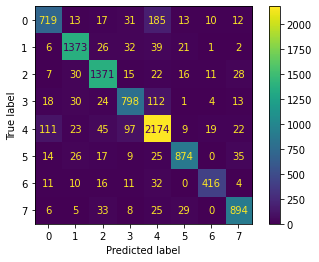

              precision    recall  f1-score   support

           0    0.80605   0.71900   0.76004      1000
           1    0.90927   0.91533   0.91229      1500
           2    0.88509   0.91400   0.89931      1500
           3    0.79720   0.79800   0.79760      1000
           4    0.83168   0.86960   0.85022      2500
           5    0.90758   0.87400   0.89047      1000
           6    0.90239   0.83200   0.86576       500
           7    0.88515   0.89400   0.88955      1000

    accuracy                        0.86190     10000
   macro avg    0.86555   0.85199   0.85816     10000
weighted avg    0.86179   0.86190   0.86135     10000


  • MEDIUM LEVEL 


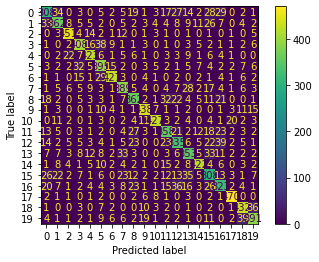

              precision    recall  f1-score   support

           0    0.67841   0.61600   0.64570       500
           1    0.75732   0.72400   0.74029       500
           2    0.88431   0.90200   0.89307       500
           3    0.79223   0.81600   0.80394       500
           4    0.83597   0.84600   0.84095       500
           5    0.72080   0.79000   0.75382       500
           6    0.89518   0.85400   0.87410       500
           7    0.75534   0.77800   0.76650       500
           8    0.73279   0.72400   0.72837       500
           9    0.85380   0.87600   0.86476       500
          10    0.91435   0.85400   0.88314       500
          11    0.71743   0.71600   0.71672       500
          12    0.68648   0.67000   0.67814       500
          13    0.70040   0.70600   0.70319       500
          14    0.86653   0.84400   0.85512       500
          15    0.58555   0.61600   0.60039       500
          16    0.65918   0.64600   0.65253       500
          17    0.91440   0

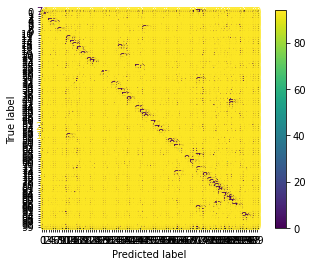

              precision    recall  f1-score   support

           0    0.51034   0.74000   0.60408       100
           1    0.00000   0.00000   0.00000       100
           2    0.26257   0.47000   0.33692       100
           3    0.30201   0.45000   0.36145       100
           4    0.00000   0.00000   0.00000       100
           5    0.44915   0.53000   0.48624       100
           6    0.59821   0.67000   0.63208       100
           7    0.62162   0.23000   0.33577       100
           8    0.00000   0.00000   0.00000       100
           9    0.67033   0.61000   0.63874       100
          10    0.24138   0.35000   0.28571       100
          11    0.00000   0.00000   0.00000       100
          12    0.00000   0.00000   0.00000       100
          13    0.31683   0.64000   0.42384       100
          14    0.29333   0.44000   0.35200       100
          15    0.29444   0.53000   0.37857       100
          16    0.40397   0.61000   0.48606       100
          17    0.00000   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.66774 
Hierarchical Recall = 0.6770666666666666 
Hierarchical F1-Score = 0.6714011904761904 
Consistency =  0.9413 
Exact Match =  0.355


# Training Again

In [22]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1447 - prediction_coarse_accuracy: 0.9217 - prediction_medium_accuracy: 0.8881 - prediction_fine_accuracy: 0.3655
  • Coarse Accuracy = 92.17% | Val_Accuracy = 82.68% | LossWeight = 0.24 
  • Medium Accuracy = 88.81% | Val_Accuracy = 71.80% | LossWeight = 0.31 
  • Fine   Accuracy = 36.55% | Val_Accuracy = 31.50% | LossWeight = 0.45 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.36330
781/781 [==============================] - 64s 81ms/step - loss: 0.1447 - prediction_coarse_accuracy: 0.9217 - prediction_medium_accuracy: 0.8881 - prediction_fine_accuracy: 0.3655 - val_loss: 0.1771 - val_prediction_coarse_accuracy: 0.8268 - val_prediction_medium_accuracy: 0.7180 - val_prediction_fine_accuracy: 0.3150 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1437 - prediction_coarse_accuracy: 0.9314 - prediction_medium_accuracy: 0.9015 - prediction_fine_accuracy: 0.3777
  

781/781 [==============================] - 50s 65ms/step - loss: 0.1279 - prediction_coarse_accuracy: 0.9404 - prediction_medium_accuracy: 0.9185 - prediction_fine_accuracy: 0.4690 - val_loss: 0.1624 - val_prediction_coarse_accuracy: 0.8433 - val_prediction_medium_accuracy: 0.7477 - val_prediction_fine_accuracy: 0.3951 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1277 - prediction_coarse_accuracy: 0.9396 - prediction_medium_accuracy: 0.9176 - prediction_fine_accuracy: 0.4775
  • Coarse Accuracy = 93.96% | Val_Accuracy = 84.00% | LossWeight = 0.24 
  • Medium Accuracy = 91.76% | Val_Accuracy = 74.51% | LossWeight = 0.29 
  • Fine   Accuracy = 47.75% | Val_Accuracy = 41.05% | LossWeight = 0.48 

Epoch 10: val_prediction_fine_accuracy improved from 0.39510 to 0.41050, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 50s 65ms/step - loss: 0.1277 - prediction_coarse_acc

781/781 [==============================] - 55s 70ms/step - loss: 0.1142 - prediction_coarse_accuracy: 0.9501 - prediction_medium_accuracy: 0.9344 - prediction_fine_accuracy: 0.5749 - val_loss: 0.1498 - val_prediction_coarse_accuracy: 0.8508 - val_prediction_medium_accuracy: 0.7626 - val_prediction_fine_accuracy: 0.4788 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1133 - prediction_coarse_accuracy: 0.9491 - prediction_medium_accuracy: 0.9347 - prediction_fine_accuracy: 0.5847
  • Coarse Accuracy = 94.91% | Val_Accuracy = 85.29% | LossWeight = 0.25 
  • Medium Accuracy = 93.47% | Val_Accuracy = 76.14% | LossWeight = 0.28 
  • Fine   Accuracy = 58.47% | Val_Accuracy = 48.30% | LossWeight = 0.47 

Epoch 19: val_prediction_fine_accuracy improved from 0.47880 to 0.48300, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 55s 70ms/step - loss: 0.1133 - prediction_coarse

Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1053 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9443 - prediction_fine_accuracy: 0.6675
  • Coarse Accuracy = 95.75% | Val_Accuracy = 85.56% | LossWeight = 0.25 
  • Medium Accuracy = 94.43% | Val_Accuracy = 77.00% | LossWeight = 0.29 
  • Fine   Accuracy = 66.75% | Val_Accuracy = 52.18% | LossWeight = 0.46 

Epoch 28: val_prediction_fine_accuracy improved from 0.51490 to 0.52180, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 96s 123ms/step - loss: 0.1053 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9443 - prediction_fine_accuracy: 0.6675 - val_loss: 0.1442 - val_prediction_coarse_accuracy: 0.8556 - val_prediction_medium_accuracy: 0.7700 - val_prediction_fine_accuracy: 0.5218 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.1043 - predictio

Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1015 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9455 - prediction_fine_accuracy: 0.7152
  • Coarse Accuracy = 95.80% | Val_Accuracy = 86.26% | LossWeight = 0.27 
  • Medium Accuracy = 94.55% | Val_Accuracy = 77.92% | LossWeight = 0.31 
  • Fine   Accuracy = 71.52% | Val_Accuracy = 54.70% | LossWeight = 0.42 

Epoch 37: val_prediction_fine_accuracy improved from 0.54540 to 0.54700, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 93s 119ms/step - loss: 0.1015 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9455 - prediction_fine_accuracy: 0.7152 - val_loss: 0.1393 - val_prediction_coarse_accuracy: 0.8626 - val_prediction_medium_accuracy: 0.7792 - val_prediction_fine_accuracy: 0.5470 - lr: 2.5034e-04
Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.1014 - predictio

Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0986 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9505 - prediction_fine_accuracy: 0.7435
  • Coarse Accuracy = 96.21% | Val_Accuracy = 86.40% | LossWeight = 0.27 
  • Medium Accuracy = 95.05% | Val_Accuracy = 78.36% | LossWeight = 0.31 
  • Fine   Accuracy = 74.35% | Val_Accuracy = 55.68% | LossWeight = 0.42 

Epoch 46: val_prediction_fine_accuracy improved from 0.55630 to 0.55680, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 96s 123ms/step - loss: 0.0986 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9505 - prediction_fine_accuracy: 0.7435 - val_loss: 0.1376 - val_prediction_coarse_accuracy: 0.8640 - val_prediction_medium_accuracy: 0.7836 - val_prediction_fine_accuracy: 0.5568 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0983 - predictio

781/781 [==============================] - 85s 109ms/step - loss: 0.0962 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.7690 - val_loss: 0.1364 - val_prediction_coarse_accuracy: 0.8667 - val_prediction_medium_accuracy: 0.7867 - val_prediction_fine_accuracy: 0.5621 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0958 - prediction_coarse_accuracy: 0.9630 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.7680
  • Coarse Accuracy = 96.30% | Val_Accuracy = 86.57% | LossWeight = 0.28 
  • Medium Accuracy = 95.38% | Val_Accuracy = 78.59% | LossWeight = 0.31 
  • Fine   Accuracy = 76.80% | Val_Accuracy = 56.18% | LossWeight = 0.41 

Epoch 65: val_prediction_fine_accuracy did not improve from 0.56360
781/781 [==============================] - 90s 115ms/step - loss: 0.0958 - prediction_coarse_accuracy: 0.9630 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.7680 

Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0973 - prediction_coarse_accuracy: 0.9614 - prediction_medium_accuracy: 0.9510 - prediction_fine_accuracy: 0.7722
  • Coarse Accuracy = 96.14% | Val_Accuracy = 86.77% | LossWeight = 0.28 
  • Medium Accuracy = 95.10% | Val_Accuracy = 78.80% | LossWeight = 0.32 
  • Fine   Accuracy = 77.22% | Val_Accuracy = 56.52% | LossWeight = 0.39 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.56730
781/781 [==============================] - 62s 79ms/step - loss: 0.0973 - prediction_coarse_accuracy: 0.9614 - prediction_medium_accuracy: 0.9510 - prediction_fine_accuracy: 0.7722 - val_loss: 0.1367 - val_prediction_coarse_accuracy: 0.8677 - val_prediction_medium_accuracy: 0.7880 - val_prediction_fine_accuracy: 0.5652 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0966 - prediction_coarse_accuracy: 0.9620 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.

781/781 [==============================] - 92s 118ms/step - loss: 0.0960 - prediction_coarse_accuracy: 0.9624 - prediction_medium_accuracy: 0.9526 - prediction_fine_accuracy: 0.7804 - val_loss: 0.1356 - val_prediction_coarse_accuracy: 0.8680 - val_prediction_medium_accuracy: 0.7879 - val_prediction_fine_accuracy: 0.5660 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0957 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9533 - prediction_fine_accuracy: 0.7769
  • Coarse Accuracy = 96.21% | Val_Accuracy = 86.67% | LossWeight = 0.29 
  • Medium Accuracy = 95.33% | Val_Accuracy = 78.79% | LossWeight = 0.32 
  • Fine   Accuracy = 77.69% | Val_Accuracy = 56.64% | LossWeight = 0.39 

Epoch 84: val_prediction_fine_accuracy did not improve from 0.56790
781/781 [==============================] - 66s 85ms/step - loss: 0.0957 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9533 - prediction_fine_accuracy: 0.7769 -

In [23]:
history_dict = history.history

(0.0, 1.0)

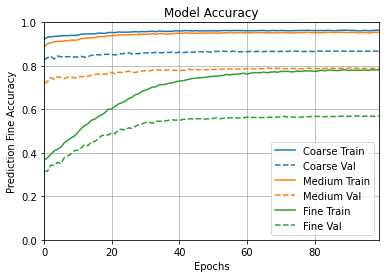

In [24]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

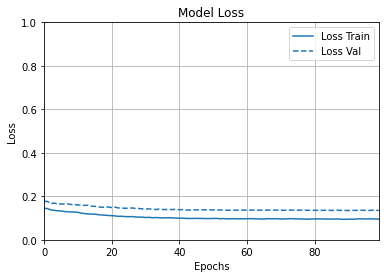

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [26]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 25ms/step - loss: 0.2212 - prediction_coarse_loss: 0.0986 - prediction_medium_loss: 0.1619 - prediction_fine_loss: 0.3565 - prediction_coarse_accuracy: 0.8678 - prediction_medium_accuracy: 0.7888 - prediction_fine_accuracy: 0.5686
1. loss ==> 0.22123423218727112
2. prediction_coarse_loss ==> 0.09863109886646271
3. prediction_medium_loss ==> 0.1618751585483551
4. prediction_fine_loss ==> 0.3564927279949188
5. prediction_coarse_accuracy ==> 0.8677999973297119
6. prediction_medium_accuracy ==> 0.7888000011444092
7. prediction_fine_accuracy ==> 0.5685999989509583
313/313 [==============================] - 6s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

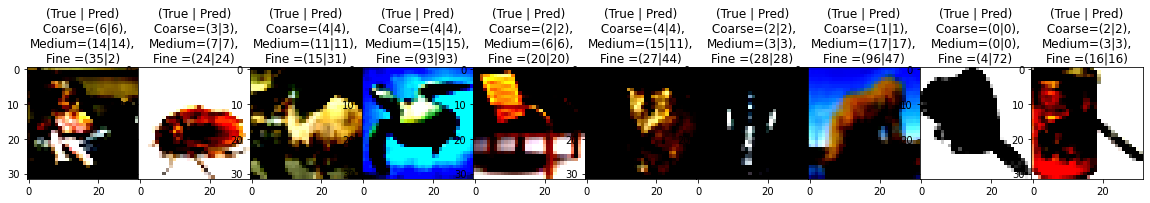

In [27]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 735   13   17   27  180    8   10   10]
 [   6 1378   32   24   40   17    1    2]
 [   1   32 1379   13   30   17    9   19]
 [  16   37   34  798  101    2    4    8]
 [  94   23   52   99 2187   12   14   19]
 [   9   26   19    5   31  877    0   33]
 [  10   11   11    7   27    0  430    4]
 [   7    2   32   11   25   29    0  894]]

  • MEDIUM LEVEL 
[[325  33   0   1   1   8   1   2  18   0   3  19  20  13   3  27  20   0
    4   2]
 [ 31 372   6   1   6   6   1   7   1   3   6   8   5   6   8  19  11   0
    1   2]
 [  0   3 458   2  12   3   0  12   0   1   1   1   0   1   0   2   0   0
    2   2]
 [  1   0   4 411  15  36   6   3   2   2   0   3   0   3   3   5   0   0
    0   6]
 [  0   2  20  11 424   7   2   2   4   1   0   2   0  10   2   5   6   2
    0   0]
 [  1   0   1  30   6 397  24   3   1   5   5   0   0   3   7   4   2   0
    3   8]
 [  1   0   1  14   2  33 429   2   0   3   1   0   2   0   3   1   2   1
    5   0]


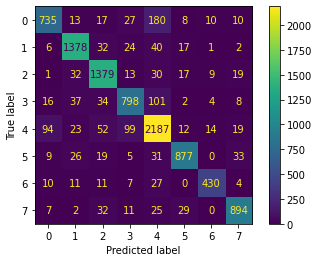

              precision    recall  f1-score   support

           0    0.83713   0.73500   0.78275      1000
           1    0.90539   0.91867   0.91198      1500
           2    0.87500   0.91933   0.89662      1500
           3    0.81098   0.79800   0.80444      1000
           4    0.83441   0.87480   0.85413      2500
           5    0.91164   0.87700   0.89399      1000
           6    0.91880   0.86000   0.88843       500
           7    0.90394   0.89400   0.89894      1000

    accuracy                        0.86780     10000
   macro avg    0.87466   0.85960   0.86641     10000
weighted avg    0.86797   0.86780   0.86725     10000


  • MEDIUM LEVEL 


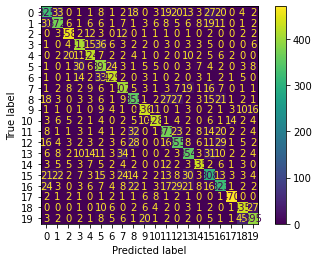

              precision    recall  f1-score   support

           0    0.69892   0.65000   0.67358       500
           1    0.79487   0.74400   0.76860       500
           2    0.88417   0.91600   0.89980       500
           3    0.80588   0.82200   0.81386       500
           4    0.82490   0.84800   0.83629       500
           5    0.68685   0.79400   0.73655       500
           6    0.86145   0.85800   0.85972       500
           7    0.76075   0.81400   0.78647       500
           8    0.71862   0.71000   0.71429       500
           9    0.87200   0.87200   0.87200       500
          10    0.89727   0.85600   0.87615       500
          11    0.74200   0.74200   0.74200       500
          12    0.72746   0.71000   0.71862       500
          13    0.72840   0.70800   0.71805       500
          14    0.88057   0.87000   0.87525       500
          15    0.62729   0.61600   0.62159       500
          16    0.68143   0.64600   0.66324       500
          17    0.93439   0

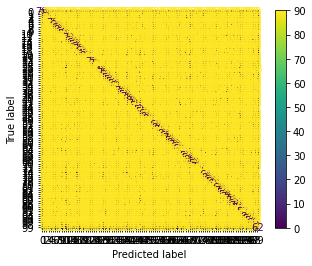

              precision    recall  f1-score   support

           0    0.84946   0.79000   0.81865       100
           1    0.82022   0.73000   0.77249       100
           2    0.44218   0.65000   0.52632       100
           3    0.56667   0.34000   0.42500       100
           4    0.00000   0.00000   0.00000       100
           5    0.54745   0.75000   0.63291       100
           6    0.74419   0.64000   0.68817       100
           7    0.60550   0.66000   0.63158       100
           8    0.51899   0.82000   0.63566       100
           9    0.90411   0.66000   0.76301       100
          10    0.38462   0.50000   0.43478       100
          11    0.40000   0.12000   0.18462       100
          12    0.51799   0.72000   0.60251       100
          13    0.60577   0.63000   0.61765       100
          14    0.51667   0.62000   0.56364       100
          15    0.41135   0.58000   0.48133       100
          16    0.55556   0.65000   0.59908       100
          17    0.90000   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [29]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7397366666666667 
Hierarchical Recall = 0.7539666666666666 
Hierarchical F1-Score = 0.7452480158730159 
Consistency =  0.9103 
Exact Match =  0.5568
